In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import Sequential, Model, optimizers
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, AveragePooling1D, MaxPooling1D
from keras.layers import Conv1D, GlobalAveragePooling1D, SimpleRNN, Bidirectional
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sn
import keras

# Import Data

In [4]:
dataset = pd.read_csv('data/data_right.csv', index_col=0)
dataset.tail()

,index,middle,ring,pinky,label
159935,"[0.20588235294117624, 0.20588235294117624, 0.2...","[0.902254409463127, 0.902254409463127, 0.90208...","[0.9900052169121742, 0.9900052169121742, 0.990...","[0.9963689704020832, 0.9963689704020832, 0.996...",4-4
159936,"[0.20517241379310305, 0.20517241379310305, 0.2...","[0.9019139943862396, 0.9019139943862396, 0.901...","[0.9896662412047679, 0.9896662412047679, 0.989...","[0.99636890657134, 0.99636890657134, 0.9963689...",4-4
159937,"[0.20309810671256565, 0.20309810671256565, 0.2...","[0.9015749535299048, 0.9015749535299048, 0.901...","[0.9893274045996283, 0.9893274045996283, 0.989...","[0.9963688975135385, 0.9963688975135385, 0.996...",4-4
159938,"[0.2013651877133101, 0.20307167235494875, 0.20...","[0.9007786395940026, 0.9007786395940026, 0.900...","[0.9884862585194406, 0.9886555782470959, 0.988...","[0.996368908937689, 0.996368908937689, 0.99636...",4-4
159939,"[0.2033898305084746, 0.2033898305084746, 0.205...","[0.9001348366181828, 0.9003040996069657, 0.900...","[0.9881515907852081, 0.9881515907852081, 0.988...","[0.9960072349640712, 0.9960072349640712, 0.996...",4-4


# Data Processing

In [5]:
## X
n_steps = len(json.loads(dataset.iloc[0,0]))
n_features = 4
X = np.empty((dataset.shape[0], n_steps, n_features))
for i in range(X.shape[0]):    
    x = np.empty((n_steps, n_features))
    for j in range(n_features):
        arr = np.array(json.loads(dataset.iloc[i,j]))
        x[:,j] = arr
    X[i] = x

## y
labels = dataset["label"].to_numpy()
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
n_classes = len(np.unique(y_encoded))
y = to_categorical(y_encoded)

## split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
print(x_train.shape, y_train.shape)

(78370, 30, 4) (78370, 25)


# Model Training

In [4]:
# define model
inputs = Input(shape=(30,4))
x = inputs
x = BatchNormalization()(x)
x = Conv1D(16,5,strides=1)(inputs)
x = Conv1D(32,5,strides=1,activation='relu')(x)
x = AveragePooling1D(3)(x)
x = BatchNormalization()(x)
x = Conv1D(64,3,strides=1)(x)
x = Conv1D(128,3,strides=1,activation='relu')(x)
x = AveragePooling1D(3)(x)
x = Bidirectional(SimpleRNN(128))(x)
# x = Flatten()(x)
x = Dense(64,'relu')(x)
x = Dropout(0.2)(x)
x = Dense(32,'relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(25,'softmax')(x)
model = Model(inputs,outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 4)]           0         
                                                                 
 conv1d (Conv1D)             (None, 26, 16)            336       
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 32)            2592      
                                                                 
 average_pooling1d (AverageP  (None, 7, 32)            0         
 ooling1D)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 7, 32)            128       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 64)             6208  

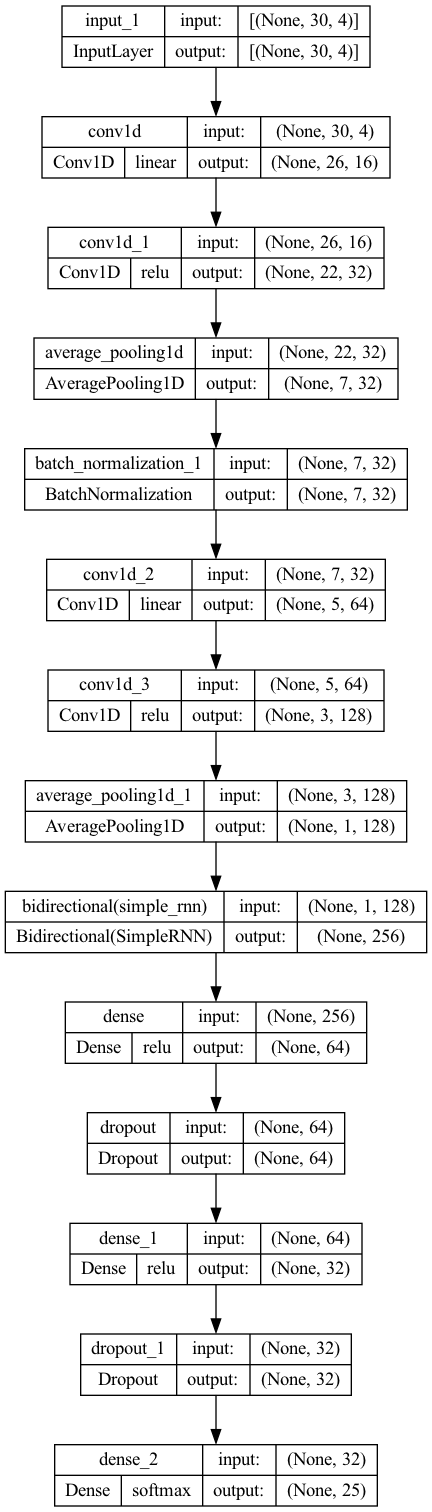

In [5]:
from keras.utils import plot_model
plot_model(model, to_file="RNN.png", show_shapes=True, show_layer_activations=True)

In [6]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy","accuracy"],
)

In [7]:
n_epochs = 20
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=n_epochs, batch_size=128)

Epoch 1/20


2023-03-30 14:10:32.818618: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


613/613 [==============================] - 4s 6ms/step - loss: 2.4931 - categorical_accuracy: 0.2595 - accuracy: 0.2595 - val_loss: 1.9745 - val_categorical_accuracy: 0.3790 - val_accuracy: 0.3790
Epoch 2/20
613/613 [==============================] - 4s 6ms/step - loss: 1.6361 - categorical_accuracy: 0.4727 - accuracy: 0.4727 - val_loss: 1.1050 - val_categorical_accuracy: 0.6497 - val_accuracy: 0.6497
Epoch 3/20
613/613 [==============================] - 4s 6ms/step - loss: 1.2284 - categorical_accuracy: 0.5885 - accuracy: 0.5885 - val_loss: 0.8733 - val_categorical_accuracy: 0.7170 - val_accuracy: 0.7170
Epoch 4/20
613/613 [==============================] - 4s 6ms/step - loss: 0.9971 - categorical_accuracy: 0.6591 - accuracy: 0.6591 - val_loss: 0.6725 - val_categorical_accuracy: 0.7659 - val_accuracy: 0.7659
Epoch 5/20
613/613 [==============================] - 4s 6ms/step - loss: 0.8520 - categorical_accuracy: 0.7075 - accuracy: 0.7075 - val_loss: 0.5192 - val_categorical_accuracy: 0

# Model Evaluation

Train accuracy: 0.8875254988670349
Validation accuracy: 0.9163392782211304
Test accuracy: 0.9179583191871643


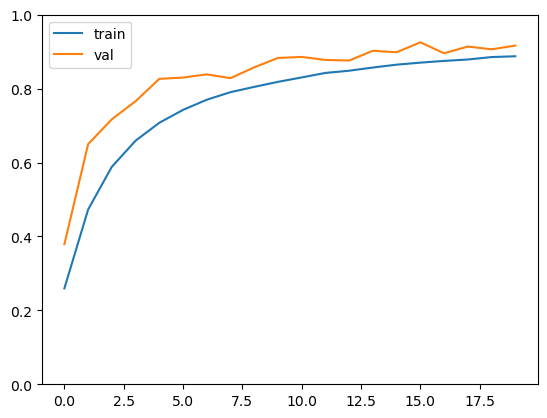

In [8]:
print("Train accuracy:", history.history["accuracy"][-1])
print("Validation accuracy:", history.history["val_accuracy"][-1])
print("Test accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.ylim((0,1))
plt.show()

In [7]:
model = keras.models.load_model("models/rnn")

2023-03-30 14:34:27.300679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-30 14:34:27.300917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 14:34:27.300973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-30 14:34:27.301016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-30 14:34:27.301047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Precision: 0.923360063595685
Recall: 0.9136861426758273
F1-score: 0.9165703549818066


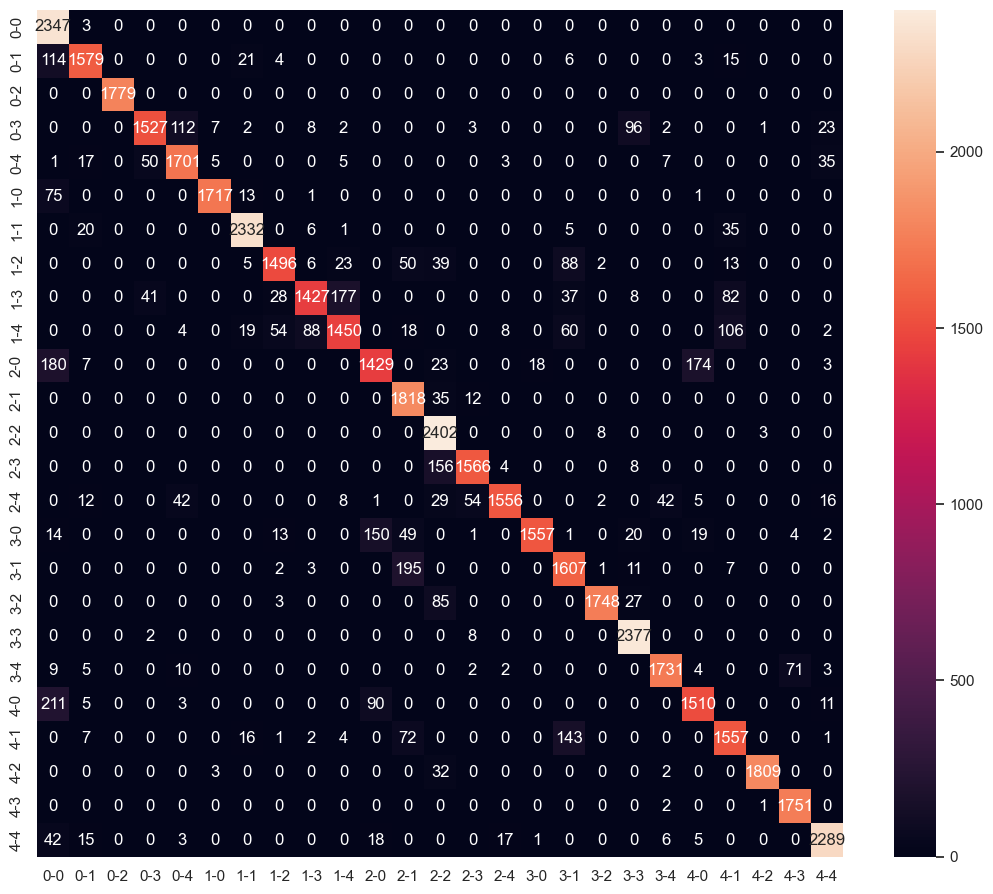

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict(x_test, verbose=0)
y_pred_rd = np.argmax(y_pred, axis=1)
y_test_rd = np.argmax(y_test, axis=1)

print("Precision:", precision_score(y_test_rd, y_pred_rd, average="macro"))
print("Recall:", recall_score(y_test_rd, y_pred_rd, average="macro"))
print("F1-score:", f1_score(y_test_rd, y_pred_rd, average="macro"))

cm = confusion_matrix(y_test_rd, y_pred_rd)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
plt.figure(figsize=(13,11))
sn.set(font_scale=1) # for label size
ticklabels = np.unique(labels)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt="d",
           xticklabels=ticklabels, yticklabels=ticklabels) # font size
plt.show()

In [10]:
import time 
times = []
for i in range(100):
    start = time.time()
    y_prediction = model.predict(x_test, verbose=0) 
    end = time.time()
    times.append((end - start)/x_test.shape[0] * 1000)
print("Inference time: %f ms" % (np.mean(np.array(times))))

Inference time: 0.025586 ms


In [14]:
import time 

start = time.time()
y_prediction = model.predict(x_test) 
end = time.time()

print("Inference time: %f ms" % ((end - start)/x_test.shape[0] * 1000))

1500/1500 [==============================] - 1s 777us/step
Inference time: 0.027598 ms


In [11]:
model.save('./models/rnn')

INFO:tensorflow:Assets written to: ./models/rnn/assets


INFO:tensorflow:Assets written to: ./models/rnn/assets


In [12]:
# import joblib

# joblib.dump(le, './save_model/label_encoder.joblib')